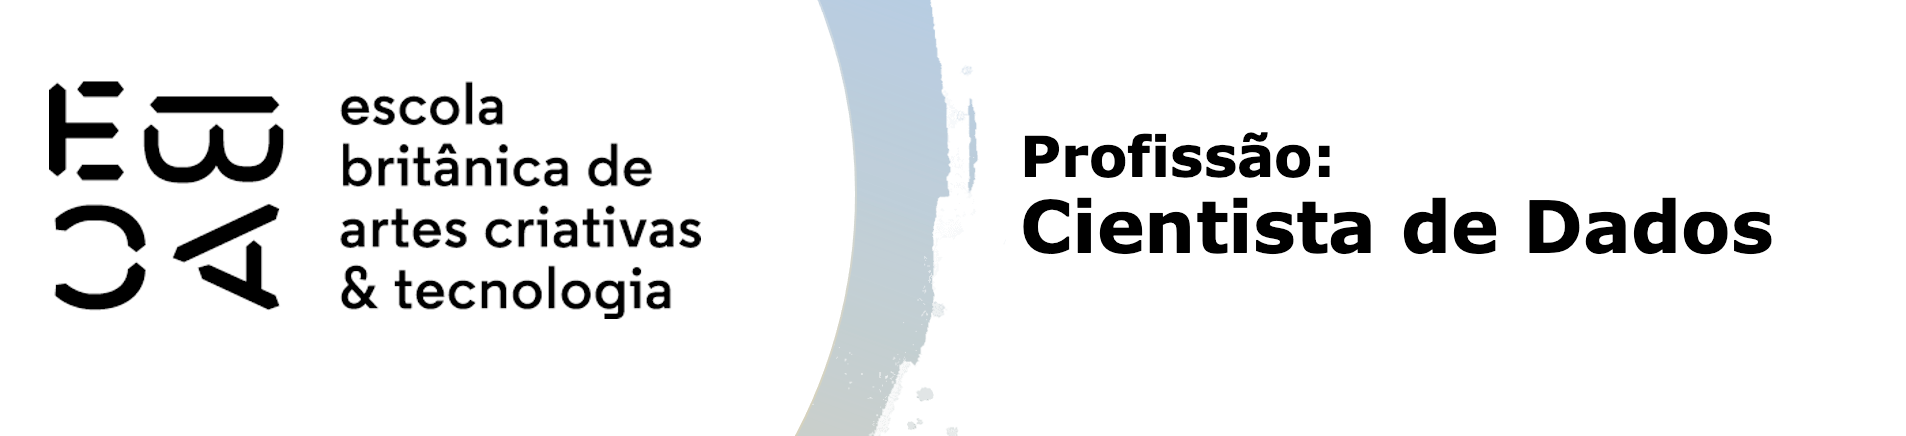

# Tarefa

Com base na tarefa realizada no módulo anterior, vamos fazer um diagnóstico do modelo.

Carregue a base ```previsao_de_renda2.csv```. Separe em uma base de treino e uma base de teste.

Vamos resgatar a melhor versão do modelod e previsão de renda que você fez para esta base. 

- Substitua missings pela média
- Rode novamente o modelo na base de treino (ou desenvolva-o caso não tenha o registro guardado). 

Este modelo deve prever a variável ```renda``` com base nas demais variáveis exceto ```data_ref``` e ```index```. Já vimos que a variável renda é melhor modelada com a transformação ```log()```, não se esqueça disso.

In [1]:
# Importando bibliotecas
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.interpolate import interp1d
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from scipy.stats import pearsonr

from joblib import dump, load

In [2]:
# Importando dados
df = pd.read_csv('../34_modulo/data/previsao_de_renda_II.csv')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14
1,2015-01-01,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81
2,2015-01-01,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66
3,2015-01-01,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84
4,2015-01-01,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78


In [3]:
# Verificando as informações
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   data_ref               750000 non-null  object 
 1   index                  750000 non-null  int64  
 2   sexo                   750000 non-null  object 
 3   posse_de_veiculo       750000 non-null  object 
 4   posse_de_imovel        750000 non-null  object 
 5   qtd_filhos             750000 non-null  int64  
 6   tipo_renda             750000 non-null  object 
 7   educacao               750000 non-null  object 
 8   estado_civil           750000 non-null  object 
 9   tipo_residencia        750000 non-null  object 
 10  idade                  750000 non-null  int64  
 11  tempo_emprego          624240 non-null  float64
 12  qt_pessoas_residencia  750000 non-null  float64
 13  renda                  750000 non-null  float64
dtypes: float64(3), int64(3), object(8)
m

In [4]:
# Copiando a df original apenas as colunas de interesse
df_copy = df.sample(5_000).copy()

# Substituindo os valores faltantes pela média
df_copy.fillna({'tempo_emprego': np.mean(df_copy['tempo_emprego'])}, inplace=True)

# Obtendo o log da renda
df_copy.loc[:, 'renda_log'] = np.log(df_copy['renda'])

# Convertendo a classe da coluna data_ref para datetime
df_copy['data_ref'] = pd.to_datetime(df_copy['data_ref'])

df_copy = load("./data/df_copy_big")

df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 306417 to 647261
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   data_ref               5000 non-null   datetime64[ns]
 1   index                  5000 non-null   int64         
 2   sexo                   5000 non-null   object        
 3   posse_de_veiculo       5000 non-null   object        
 4   posse_de_imovel        5000 non-null   object        
 5   qtd_filhos             5000 non-null   int64         
 6   tipo_renda             5000 non-null   object        
 7   educacao               5000 non-null   object        
 8   estado_civil           5000 non-null   object        
 9   tipo_residencia        5000 non-null   object        
 10  idade                  5000 non-null   int64         
 11  tempo_emprego          5000 non-null   float64       
 12  qt_pessoas_residencia  5000 non-null   float64       
 13  r

In [5]:
# Obtendo a base de teste
df_copy_test = df_copy.tail(int(len(df_copy)*.1))
df_copy_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 288555 to 647261
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   data_ref               500 non-null    datetime64[ns]
 1   index                  500 non-null    int64         
 2   sexo                   500 non-null    object        
 3   posse_de_veiculo       500 non-null    object        
 4   posse_de_imovel        500 non-null    object        
 5   qtd_filhos             500 non-null    int64         
 6   tipo_renda             500 non-null    object        
 7   educacao               500 non-null    object        
 8   estado_civil           500 non-null    object        
 9   tipo_residencia        500 non-null    object        
 10  idade                  500 non-null    int64         
 11  tempo_emprego          500 non-null    float64       
 12  qt_pessoas_residencia  500 non-null    float64       
 13  re

In [6]:
# Obtendo a base de treino
df_copy_train = df_copy.drop(df_copy_test.index)
df_copy_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4500 entries, 306417 to 534802
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   data_ref               4500 non-null   datetime64[ns]
 1   index                  4500 non-null   int64         
 2   sexo                   4500 non-null   object        
 3   posse_de_veiculo       4500 non-null   object        
 4   posse_de_imovel        4500 non-null   object        
 5   qtd_filhos             4500 non-null   int64         
 6   tipo_renda             4500 non-null   object        
 7   educacao               4500 non-null   object        
 8   estado_civil           4500 non-null   object        
 9   tipo_residencia        4500 non-null   object        
 10  idade                  4500 non-null   int64         
 11  tempo_emprego          4500 non-null   float64       
 12  qt_pessoas_residencia  4500 non-null   float64       
 13  r

In [7]:
# Retirando colunas que não serão usadas
df_copy_test = df_copy_test.drop(['data_ref','index', 'renda'], axis=1)
df_copy_train = df_copy_train.drop(['data_ref','index', 'renda'], axis=1)

display(df_copy_test.info())
display(df_copy_train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 288555 to 647261
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sexo                   500 non-null    object 
 1   posse_de_veiculo       500 non-null    object 
 2   posse_de_imovel        500 non-null    object 
 3   qtd_filhos             500 non-null    int64  
 4   tipo_renda             500 non-null    object 
 5   educacao               500 non-null    object 
 6   estado_civil           500 non-null    object 
 7   tipo_residencia        500 non-null    object 
 8   idade                  500 non-null    int64  
 9   tempo_emprego          500 non-null    float64
 10  qt_pessoas_residencia  500 non-null    float64
 11  renda_log              500 non-null    float64
dtypes: float64(3), int64(2), object(7)
memory usage: 50.8+ KB


None

<class 'pandas.core.frame.DataFrame'>
Index: 4500 entries, 306417 to 534802
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sexo                   4500 non-null   object 
 1   posse_de_veiculo       4500 non-null   object 
 2   posse_de_imovel        4500 non-null   object 
 3   qtd_filhos             4500 non-null   int64  
 4   tipo_renda             4500 non-null   object 
 5   educacao               4500 non-null   object 
 6   estado_civil           4500 non-null   object 
 7   tipo_residencia        4500 non-null   object 
 8   idade                  4500 non-null   int64  
 9   tempo_emprego          4500 non-null   float64
 10  qt_pessoas_residencia  4500 non-null   float64
 11  renda_log              4500 non-null   float64
dtypes: float64(3), int64(2), object(7)
memory usage: 457.0+ KB


None

In [8]:
# Define a suavização dos dados na variável lowess
lowess = sm.nonparametric.lowess(df_copy_train['renda_log'], df_copy_train['tempo_emprego'], frac=1/9)

# Valores de X e Y suavizados
f = interp1d(lowess[:, 0], lowess[:, 1], bounds_error=False)

df_copy_train.loc[:, 'tempo_emprego_lowess'] = f(df_copy_train['tempo_emprego'])
df_copy_train.head()

d:\OneDrive\Program\01 - scripts-base\EBAC\ebac_env\lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda_log,tempo_emprego_lowess
306417,M,S,S,0,Assalariado,Superior completo,Casado,Com os pais,33,7.128767,2.0,10.936314,9.079192
11394,M,S,S,0,Assalariado,Superior incompleto,Casado,Casa,33,4.347945,2.0,7.804900,8.741837
357633,F,S,S,0,Empresário,Médio,Casado,Casa,49,6.890411,2.0,10.795376,9.024123
441289,F,S,N,0,Assalariado,Superior completo,Casado,Comunitário,35,6.263014,2.0,10.502375,8.926618
425065,F,S,N,1,Empresário,Superior completo,Solteiro,Casa,27,4.523288,2.0,10.120116,8.717967


In [9]:
df_copy_train.columns

Index(['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'qtd_filhos',
       'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia', 'idade',
       'tempo_emprego', 'qt_pessoas_residencia', 'renda_log',
       'tempo_emprego_lowess'],
      dtype='object')

In [10]:
# Obtendo a primeira regreção com todas as variáveis
formula = '''
            renda_log ~ 
            + sexo
            + posse_de_veiculo
            + posse_de_imovel
            + qtd_filhos
            + tipo_renda
            + educacao
            + estado_civil
            + tipo_residencia
            + idade
            + tempo_emprego
            + qt_pessoas_residencia
            + tempo_emprego_lowess
'''
reg = smf.ols(formula=formula, data=df_copy_train).fit()

reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              renda_log   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.399
Method:                 Least Squares   F-statistic:                     120.4
Date:                Sun, 29 Dec 2024   Prob (F-statistic):               0.00
Time:                        18:56:01   Log-Likelihood:                -6277.6
No. Observations:                4500   AIC:                         1.261e+04
Df Residuals:                    4474   BIC:                         1.277e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            0.6754      1.698      0.398      0.691      -2.654       4.005
sexo[T.M]                            0.0308      0.034      0.899      0.369      -0.036       0.098
posse_de_veiculo[T.S]                0.0789      0.033      2.406      0.016       0.015       0.143
posse_de_imovel[T.S]                 0.1431      0.032      4.418      0.000       0.080       0.207
tipo_renda[T.Bolsista]               0.2784      0.440      0.633      0.527      -0.584       1.141
tipo_renda[T.Empresário]             0.1316      0.037      3.530      0.000       0.059       0.205
tipo_renda[T.Pensionista]            1.4713      0.426      3.455      0.001       0.636       2.306
tipo_renda[T.Servidor público]       0.0714      0.055      1.307      0.191      -0.036       0.179
educacao[T.Médio]                   -0.0358      0.146     -0.245      0.806      -0.322       0.251
educacao[T.Pós graduação]            0.6789      0.585      1.161      0.246      -0.467       1.825
educacao[T.Superior completo]       -0.0551      0.147     -0.374      0.708      -0.344       0.234
educacao[T.Superior incompleto]     -0.1252      0.163     -0.770      0.441      -0.444       0.193
estado_civil[T.Separado]            -0.1478      0.206     -0.716      0.474      -0.552       0.257
estado_civil[T.Solteiro]            -0.1608      0.200     -0.803      0.422      -0.554       0.232
estado_civil[T.União]                0.0351      0.057      0.619      0.536      -0.076       0.146
estado_civil[T.Viúvo]               -0.1335      0.210     -0.634      0.526      -0.546       0.279
tipo_residencia[T.Casa]              0.3553      0.127      2.799      0.005       0.106       0.604
tipo_residencia[T.Com os pais]       0.4488      0.146      3.084      0.002       0.163       0.734
tipo_residencia[T.Comunitário]      -0.0403      0.283     -0.142      0.887      -0.595       0.515
tipo_residencia[T.Estúdio]           0.3568      0.203      1.757      0.079      -0.041       0.755
tipo_residencia[T.Governamental]     0.2993      0.151      1.981      0.048       0.003       0.596
qtd_filhos                           0.1433      0.197      0.727      0.467      -0.243       0.530
idade                                0.0055      0.002      2.879      0.004       0.002       0.009
tempo_emprego                        0.0156      0.026      0.607      0.544      -0.035       0.066
qt_pessoas_residencia               -0.1549      0.197     -0.788      0.431      -0.540       0.230
tempo_emprego_lowess                 0.8682      0.201      4.323      0.000       0.475       1.262
==============================================================================
Omnibus:                       45.761   Durbin-Watson:                   1.

In [11]:
# Obtendo a primeira regreção com todas as variáveis
formula = '''
            renda_log ~ 
            C(tipo_renda, Treatment('Pensionista')) +
            tempo_emprego_lowess
'''
reg_redc = smf.ols(formula=formula, data=df_copy_train).fit()

reg_redc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              renda_log   R-squared:                       0.394
Model:                            OLS   Adj. R-squared:                  0.394
Method:                 Least Squares   F-statistic:                     584.9
Date:                Sun, 29 Dec 2024   Prob (F-statistic):               0.00
Time:                        18:56:01   Log-Likelihood:                -6307.2
No. Observations:                4500   AIC:                         1.263e+04
Df Residuals:                    4494   BIC:                         1.266e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================================================================
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------
Intercept                                                       1.7521      0.138     12.662      0.000       1.481       2.023
C(tipo_renda, Treatment('Pensionista'))[T.Assalariado]         -1.8823      0.058    -32.563      0.000      -1.996      -1.769
C(tipo_renda, Treatment('Pensionista'))[T.Bolsista]            -1.5461      0.444     -3.485      0.000      -2.416      -0.676
C(tipo_renda, Treatment('Pensionista'))[T.Empresário]          -1.7545      0.060    -29.366      0.000      -1.872      -1.637
C(tipo_renda, Treatment('Pensionista'))[T.Servidor público]    -1.8274      0.077    -23.636      0.000      -1.979      -1.676
tempo_emprego_lowess                                            1.0091      0.019     52.997      0.000       0.972       1.046
==============================================================================
Omnibus:                       43.904   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.868
Skew:                          -0.064   Prob(JB):                     3.27e-07
Kurtosis:                       2.622   Cond. No.                         270.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Verifique as suposições do modelo

Faça uma análise para avaliar as suposições básicas:

- Os resíduos desse modelo possuem distribuição Normal (ou algo próximo)?
- Verifique a independência dos resíduos
    - Faça um gráfico dos resíduos versus os valores preditos
    - Avalie se há padrões dos resíduos versus cada uma das variáveis do modelo
    - Avalie se o valor médio dos resíduos aparenta ter relação com o mês de referência
- Avalie se a variância da variável resposta parece ser conforme os valores previstos.

Você considera que as suposições estão atendidas? Há algum impacto em eventuais desvios?

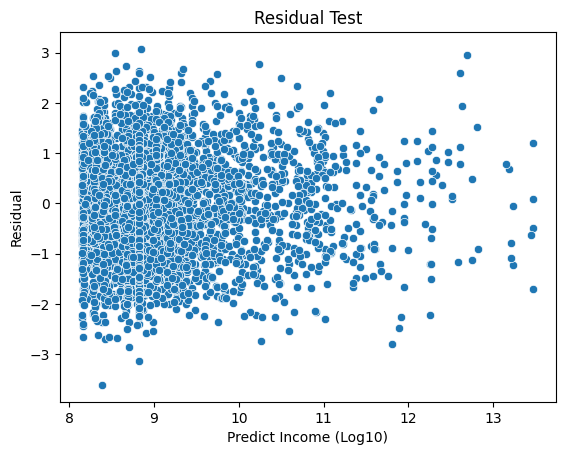

In [12]:
plt.title("Residual Test")
sns.scatterplot(
    x=reg_redc.predict(),
    y=reg_redc.resid
)
plt.xlabel("Predict Income (Log10)")
plt.ylabel("Residual")
plt.show()

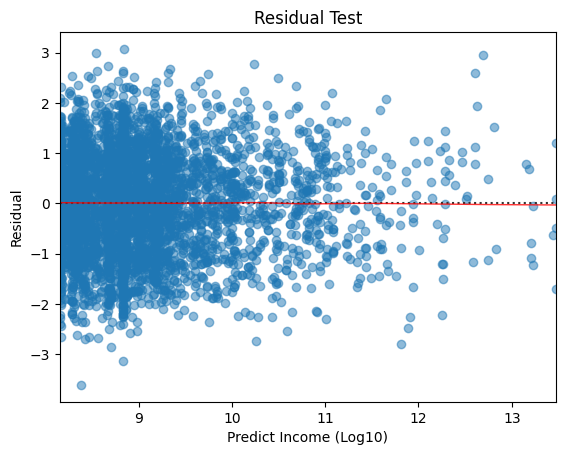

In [13]:
plt.title("Residual Test")
sns.residplot(
    x=reg_redc.predict(),
    y='renda_log',
    data=df_copy_train,
    lowess=True,
    scatter_kws={'alpha': 0.5},
    line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}
)
plt.xlabel("Predict Income (Log10)")
plt.ylabel("Residual")
plt.show()

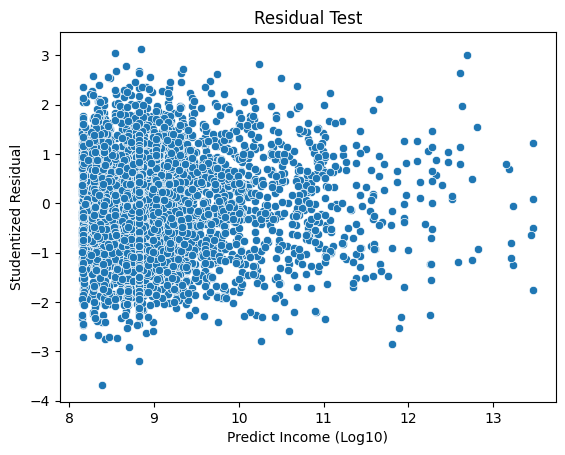

In [14]:
plt.title("Residual Test")
sns.scatterplot(
    x=reg_redc.predict(),
    y=reg_redc.outlier_test().student_resid # residual divided by its estimated standard deviation.
)
plt.xlabel("Predict Income (Log10)")
plt.ylabel("Studentized Residual")
plt.show()

d:\OneDrive\Program\01 - scripts-base\EBAC\ebac_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


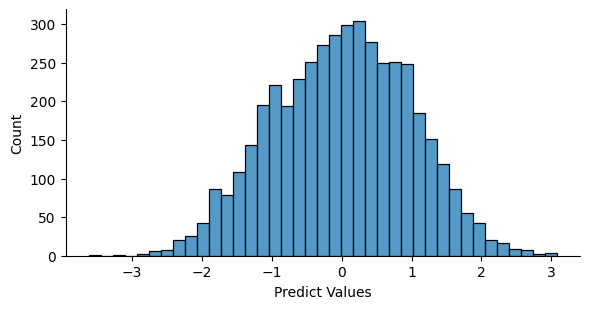

In [15]:
# plt.title("Residual Test")
sns.displot(
    reg_redc.resid,
    height=3,
    aspect=2
)
plt.xlabel("Predict Values")
plt.show()

## Outliers

Avalie os *studentized residuals*, verifique se há pontos que parecem ser discrepantes.

Avalie se há pontos influentes.

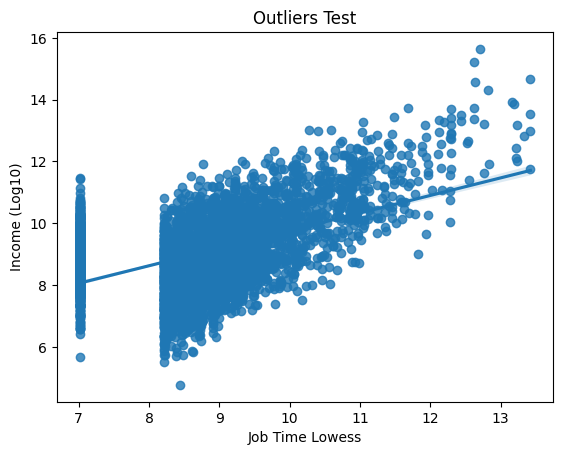

In [16]:
fig, ax = plt.subplots()
sns.regplot(
    x='tempo_emprego_lowess',
    y='renda_log',
    data=df_copy_train,
    ax=ax,
)
ax.set(
    title="Outliers Test",
    xlabel="Job Time Lowess",
    ylabel="Income (Log10)",
)
plt.show()

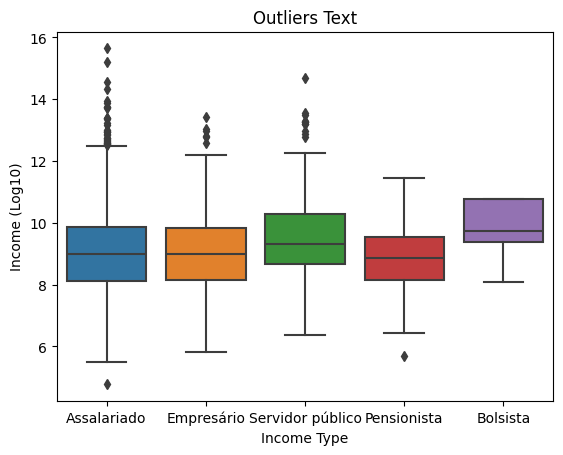

In [17]:
fig, ax = plt.subplots()
sns.boxplot(
    x='tipo_renda',
    y='renda_log',
    data=df_copy_train,
    ax=ax,
)
ax.set(
    title="Outliers Text",
    xlabel="Income Type",
    ylabel="Income (Log10)",
)
plt.show()

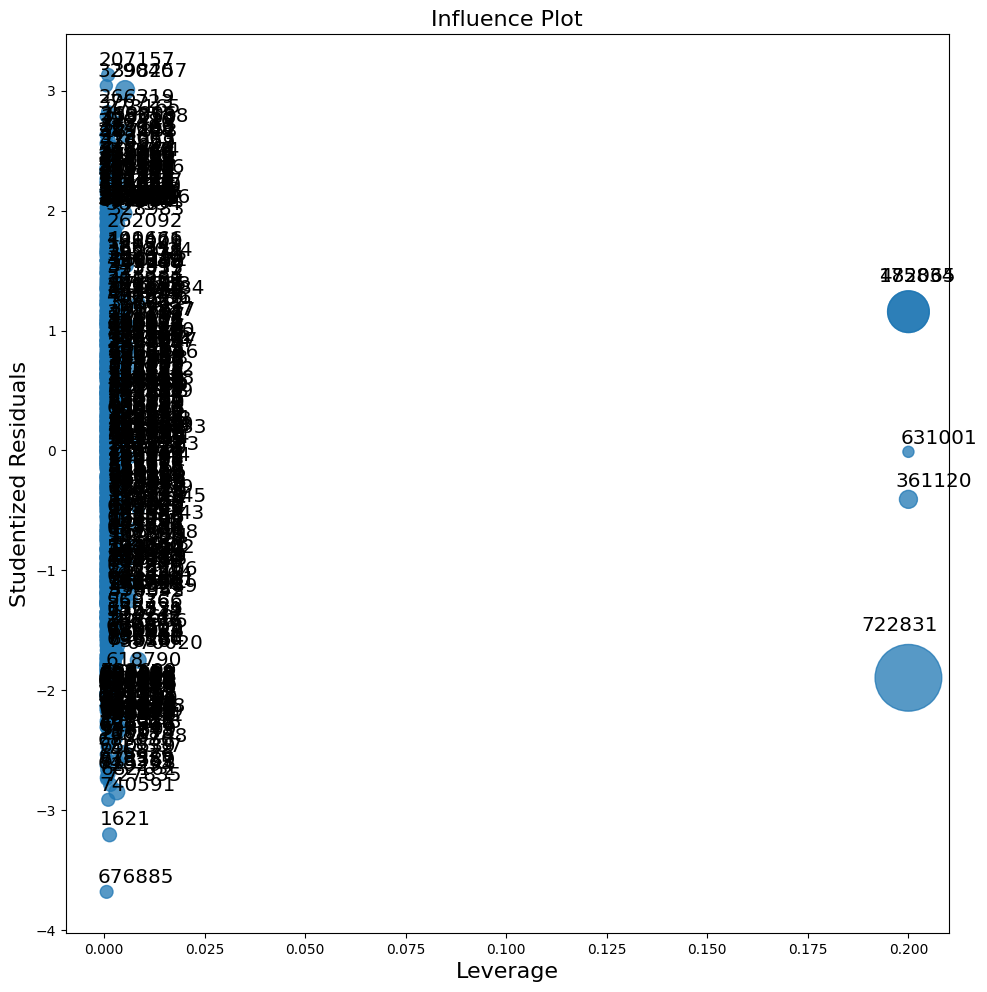

In [18]:
fig = sm.graphics.influence_plot(reg_redc, criterion="cooks")
fig.set_figheight(10)
fig.set_figwidth(10)
fig.tight_layout(pad=1.0)
plt.show()

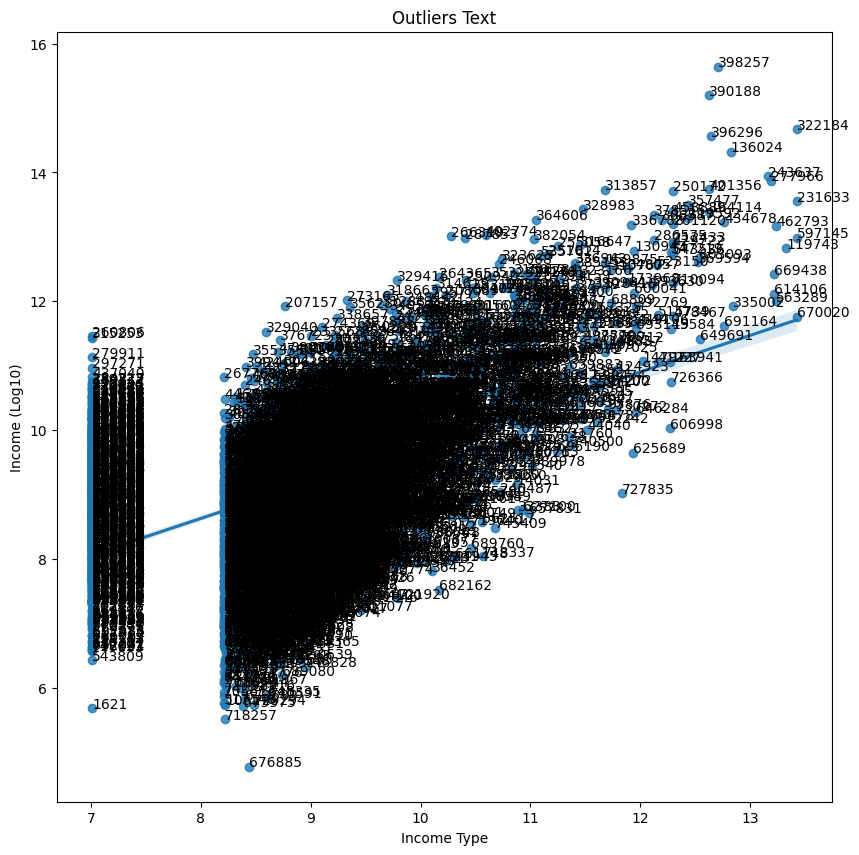

In [19]:
teste_index = [722831, 631001, 361120]
fig, ax = plt.subplots(figsize=(10,10))
sns.regplot(
    x='tempo_emprego_lowess',
    y='renda_log',
    data=df_copy_train,
    ax=ax,
)
for i, txt in enumerate(df_copy_train.index.values):
    ax.annotate(str(txt), (df_copy_train.iloc[i,-1], df_copy_train.iloc[i,-2]))
    if txt in teste_index:
        x = df_copy_train.iloc[i,-1]
        y = df_copy_train.iloc[i,-2]
        plt.scatter(x, y, color='red', s=2_000)

ax.set(
    title="Outliers Text",
    xlabel="Income Type",
    ylabel="Income (Log10)",
)
plt.show()

In [20]:
reg_redc_summary_frame = reg_redc.get_influence().summary_frame()
reg_redc_summary_frame.head()

,dfb_Intercept,"dfb_C(tipo_renda, Treatment('Pensionista'))[T.Assalariado]","dfb_C(tipo_renda, Treatment('Pensionista'))[T.Bolsista]","dfb_C(tipo_renda, Treatment('Pensionista'))[T.Empresário]","dfb_C(tipo_renda, Treatment('Pensionista'))[T.Servidor público]",dfb_tempo_emprego_lowess,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
306417,0.002063,0.015593,0.000223,0.001303,0.001288,-0.002136,0.000268,1.936750,0.000429,0.040120,1.937343,0.040132
11394,-0.006648,-0.011372,-0.000718,-0.004201,-0.004152,0.006886,0.000066,-0.901780,0.000486,-0.019885,-0.901761,-0.019884
357633,-0.003011,-0.002178,-0.000325,0.025719,-0.001881,0.003119,0.000483,1.720456,0.000978,0.053829,1.720832,0.053840
441289,0.006473,0.016709,0.000699,0.004090,0.004043,-0.006704,0.000202,1.652025,0.000444,0.034825,1.652343,0.034832
425065,0.005360,0.003876,0.000579,0.025023,0.003347,-0.005551,0.000301,1.347821,0.000992,0.042464,1.347944,0.042467


In [21]:
hat_diag_max = reg_redc_summary_frame['hat_diag'].max()
teste_index = list(reg_redc_summary_frame[(reg_redc_summary_frame['hat_diag'] == hat_diag_max)].index.values)
teste_index

[631001, 175834, 482065, 722831, 361120]

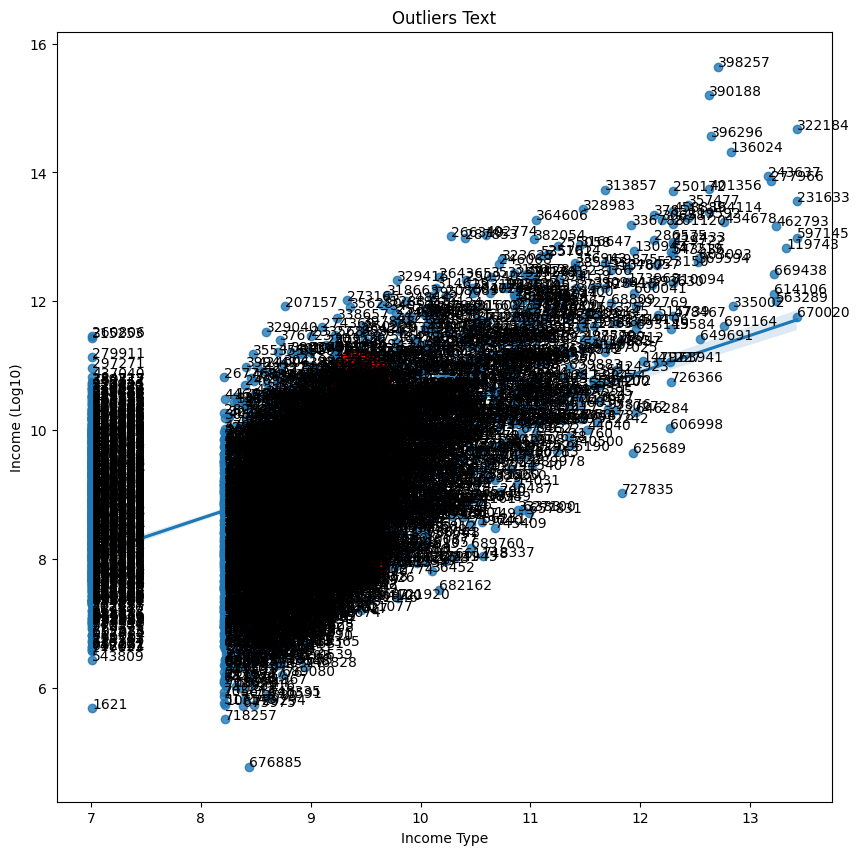

In [22]:
fig, ax = plt.subplots(figsize=(10,10))
sns.regplot(
    x='tempo_emprego_lowess',
    y='renda_log',
    data=df_copy_train,
    ax=ax,
)
for i, txt in enumerate(df_copy_train.index.values):
    ax.annotate(str(txt), (df_copy_train.iloc[i,-1], df_copy_train.iloc[i,-2]))
    if txt in teste_index:
        x = df_copy_train.iloc[i,-1]
        y = df_copy_train.iloc[i,-2]
        plt.scatter(x, y, color='red', s=2_000)

ax.set(
    title="Outliers Text",
    xlabel="Income Type",
    ylabel="Income (Log10)",
)
plt.show()

In [23]:
df_copy_train = df_copy_train.drop(teste_index)
df_copy_train = df_copy_train[(df_copy_train['renda_log'] > 8) & (df_copy_train['tempo_emprego_lowess'] < 13.4)]
df_copy_train.sort_values('renda_log').head()

,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda_log,tempo_emprego_lowess
609749,F,N,S,0,Empresário,Médio,Casado,Casa,44,5.972603,2.0,8.000329,8.912835
610296,M,S,N,0,Assalariado,Superior completo,União,Casa,32,8.471233,2.0,8.003564,9.222822
154150,F,N,S,0,Pensionista,Médio,Casado,Casa,62,7.778275,2.0,8.004382,7.012160
692826,F,N,N,1,Empresário,Superior completo,Separado,Casa,29,8.673973,2.0,8.005060,9.249416
593597,F,N,S,0,Pensionista,Médio,Viúvo,Casa,57,7.778275,1.0,8.006001,7.012160


In [24]:
df_copy_train.sort_values('renda_log').tail()

,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda_log,tempo_emprego_lowess
243637,F,N,S,0,Assalariado,Médio,Viúvo,Casa,62,39.282192,1.0,13.939646,13.165147
136024,F,N,S,0,Assalariado,Superior completo,Solteiro,Casa,62,36.753425,1.0,14.322255,12.823993
396296,F,N,S,0,Assalariado,Médio,Separado,Casa,54,35.389041,1.0,14.566624,12.642047
390188,F,N,S,0,Assalariado,Médio,Casado,Casa,61,35.260274,2.0,15.202736,12.625009
398257,F,N,N,0,Assalariado,Médio,Solteiro,Casa,56,35.895890,1.0,15.641703,12.709356


In [25]:
df_copy_train.sort_values('tempo_emprego_lowess').tail()

,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda_log,tempo_emprego_lowess
614106,F,N,S,1,Assalariado,Superior completo,Casado,Casa,58,39.652055,3.0,12.115116,13.215171
669438,F,N,S,1,Assalariado,Superior completo,Casado,Casa,58,39.652055,3.0,12.422177,13.215171
563289,F,N,S,0,Assalariado,Médio,Casado,Casa,60,39.824658,2.0,12.000415,13.238509
462793,F,N,S,0,Assalariado,Médio,Casado,Casa,60,39.824658,2.0,13.171865,13.238509
119743,F,N,S,0,Empresário,Médio,Casado,Casa,62,40.479452,2.0,12.822083,13.326983


In [26]:
# Obtendo a primeira regreção com todas as variáveis
formula = '''
            renda_log ~ 
            C(tipo_renda, Treatment('Pensionista')) +
            tempo_emprego_lowess
'''
reg_redc_out = smf.ols(formula=formula, data=df_copy_train).fit()

reg_redc_out.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              renda_log   R-squared:                       0.404
Model:                            OLS   Adj. R-squared:                  0.404
Method:                 Least Squares   F-statistic:                     603.1
Date:                Sun, 29 Dec 2024   Prob (F-statistic):               0.00
Time:                        18:58:41   Log-Likelihood:                -4200.6
No. Observations:                3557   AIC:                             8411.
Df Residuals:                    3552   BIC:                             8442.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================================================================
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------
Intercept                                                       3.6232      0.121     29.997      0.000       3.386       3.860
C(tipo_renda, Treatment('Pensionista'))[T.Assalariado]         -1.3862      0.053    -26.191      0.000      -1.490      -1.282
C(tipo_renda, Treatment('Pensionista'))[T.Empresário]          -1.2992      0.054    -24.045      0.000      -1.405      -1.193
C(tipo_renda, Treatment('Pensionista'))[T.Servidor público]    -1.4491      0.068    -21.391      0.000      -1.582      -1.316
tempo_emprego_lowess                                            0.7901      0.017     47.636      0.000       0.758       0.823
==============================================================================
Omnibus:                       36.077   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.056
Skew:                           0.249   Prob(JB):                     8.98e-09
Kurtosis:                       2.957   Cond. No.                         92.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

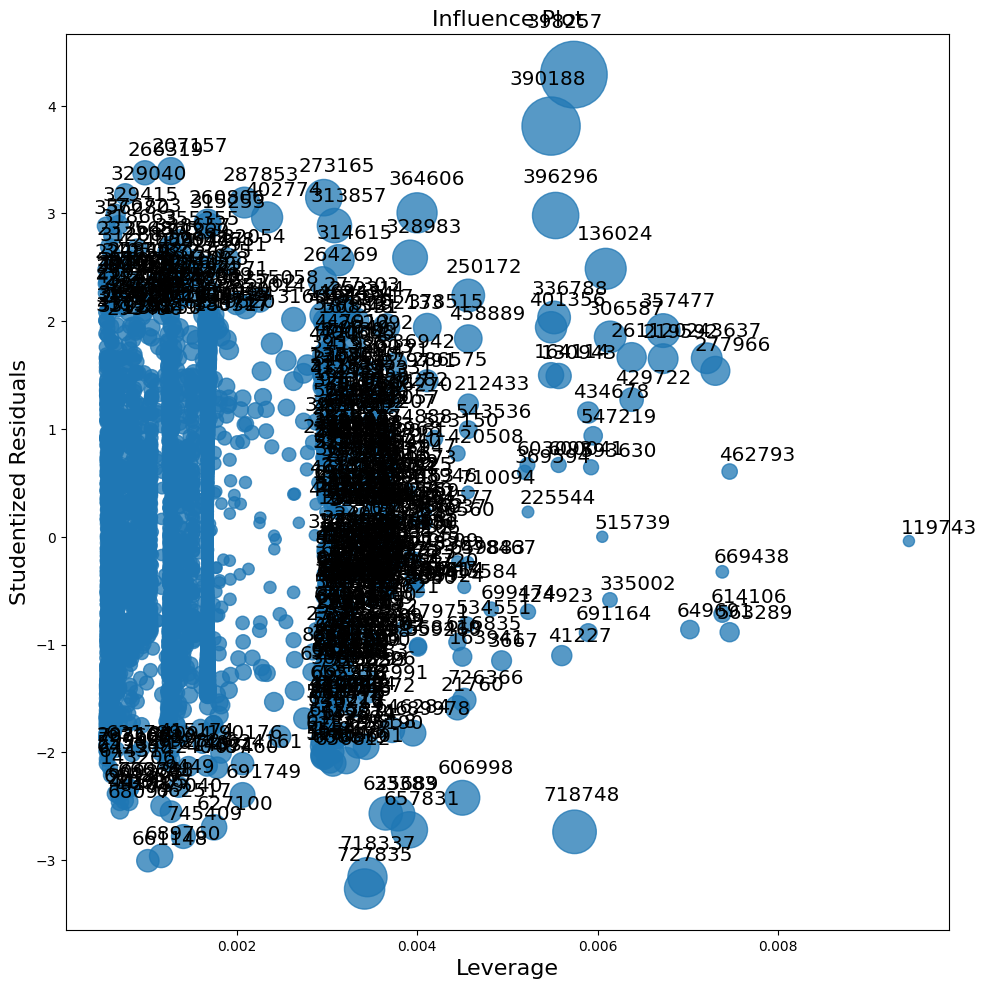

In [27]:
fig = sm.graphics.influence_plot(reg_redc_out, criterion="cooks")
fig.set_figheight(10)
fig.set_figwidth(10)
fig.tight_layout(pad=1.0)
plt.show()

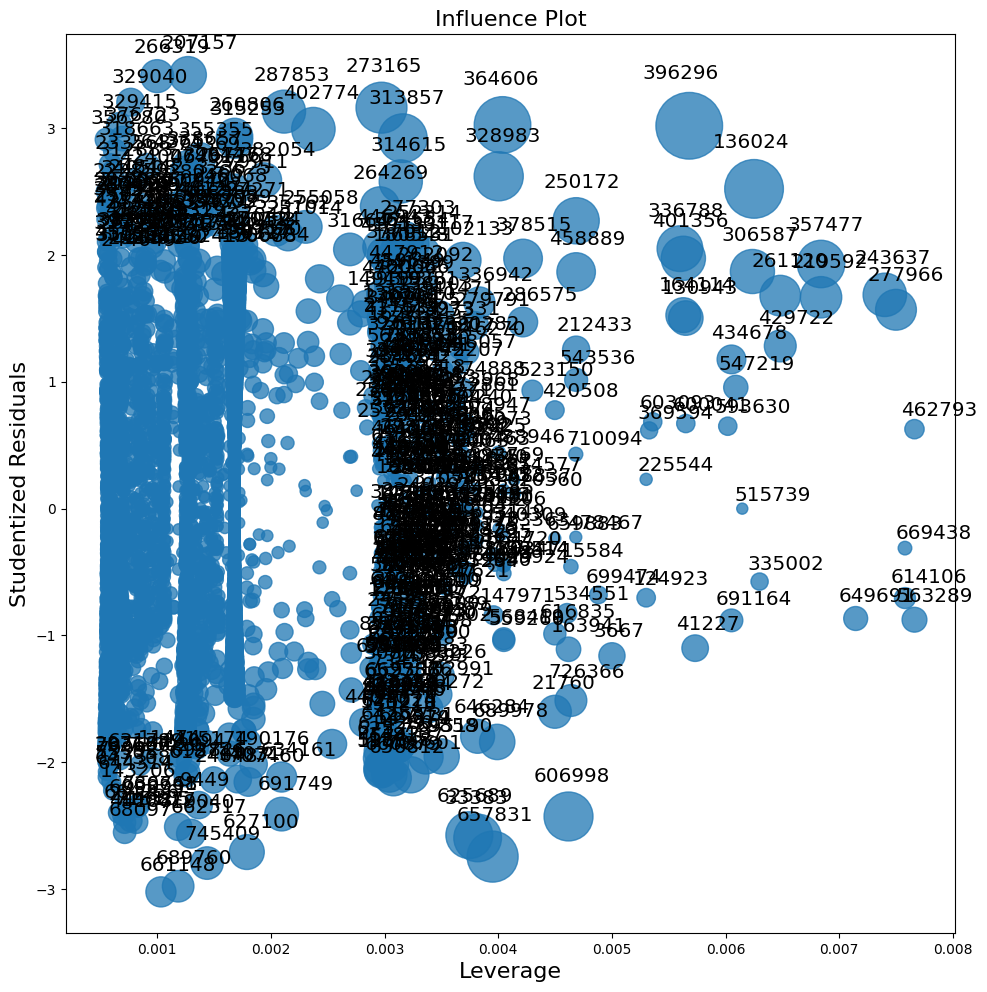

In [28]:
teste_index = [390188, 398257, 119743, 727835, 718337, 718748]
df_copy_train = df_copy_train.drop(teste_index)

# Obtendo a primeira regreção com todas as variáveis
formula = '''
            renda_log ~ 
            C(tipo_renda, Treatment('Pensionista')) +
            tempo_emprego_lowess
'''
reg_redc_out = smf.ols(formula=formula, data=df_copy_train).fit()
fig = sm.graphics.influence_plot(reg_redc_out, criterion="cooks")
fig.set_figheight(10)
fig.set_figwidth(10)
fig.tight_layout(pad=1.0)
plt.show()

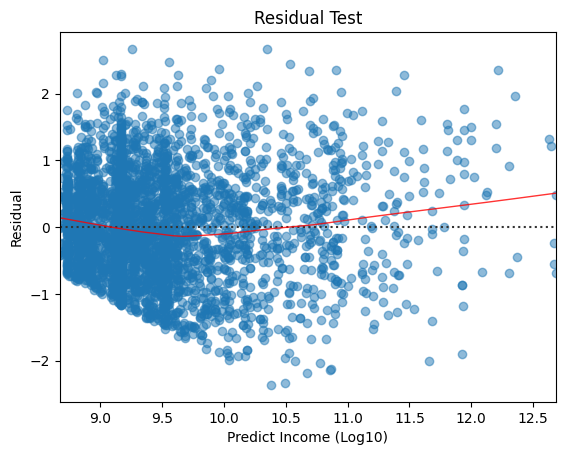

In [29]:
plt.title("Residual Test")
sns.residplot(
    x=reg_redc_out.predict(),
    y='renda_log',
    data=df_copy_train,
    lowess=True,
    scatter_kws={'alpha': 0.5},
    line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}
)
plt.xlabel("Predict Income (Log10)")
plt.ylabel("Residual")
plt.show()

## Multicolinearidade

Avalie se há questões relacionadas a multicolinearidade através de pelo menos:

- Matriz de correlação de Spearman
- VIF

In [30]:
df_copy_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3551 entries, 306417 to 534802
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sexo                   3551 non-null   object 
 1   posse_de_veiculo       3551 non-null   object 
 2   posse_de_imovel        3551 non-null   object 
 3   qtd_filhos             3551 non-null   int64  
 4   tipo_renda             3551 non-null   object 
 5   educacao               3551 non-null   object 
 6   estado_civil           3551 non-null   object 
 7   tipo_residencia        3551 non-null   object 
 8   idade                  3551 non-null   int64  
 9   tempo_emprego          3551 non-null   float64
 10  qt_pessoas_residencia  3551 non-null   float64
 11  renda_log              3551 non-null   float64
 12  tempo_emprego_lowess   3551 non-null   float64
dtypes: float64(4), int64(2), object(7)
memory usage: 388.4+ KB


In [31]:
correlation_matrix = df_copy_train.select_dtypes(['float64','int64']).corr(method='spearman')
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
correlation_matrix

,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda_log,tempo_emprego_lowess
qtd_filhos,1.000000,-0.416658,-0.099750,0.823588,-0.054081,0.103021
idade,-0.416658,1.000000,0.261864,-0.350835,0.083312,-0.216672
tempo_emprego,-0.099750,0.261864,1.000000,-0.063657,0.452494,0.702784
qt_pessoas_residencia,0.823588,-0.350835,-0.063657,1.000000,-0.036338,0.116769
renda_log,-0.054081,0.083312,0.452494,-0.036338,1.000000,0.440637
tempo_emprego_lowess,0.103021,-0.216672,0.702784,0.116769,0.440637,1.000000


d:\OneDrive\Program\01 - scripts-base\EBAC\ebac_env\lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


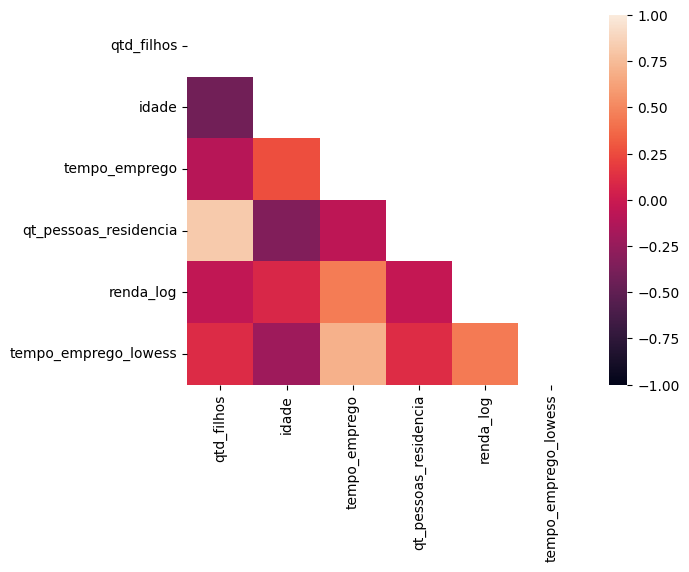

In [32]:
sns.heatmap(
    data=correlation_matrix,
    vmax=1,
    vmin=-1,
    annot=True,
    mask=mask
)
plt.show()

In [33]:
variaveis = df_copy_train.select_dtypes('object').columns

df_copy_train_dum = pd.get_dummies(df_copy_train, drop_first=True)
df_copy_train_dum.head()

,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda_log,tempo_emprego_lowess,sexo_M,posse_de_veiculo_S,posse_de_imovel_S,tipo_renda_Empresário,...,educacao_Superior incompleto,estado_civil_Separado,estado_civil_Solteiro,estado_civil_União,estado_civil_Viúvo,tipo_residencia_Casa,tipo_residencia_Com os pais,tipo_residencia_Comunitário,tipo_residencia_Estúdio,tipo_residencia_Governamental
306417,0,33,7.128767,2.0,10.936314,9.079192,True,True,True,False,...,False,False,False,False,False,False,True,False,False,False
357633,0,49,6.890411,2.0,10.795376,9.024123,False,True,True,True,...,False,False,False,False,False,True,False,False,False,False
441289,0,35,6.263014,2.0,10.502375,8.926618,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False
425065,1,27,4.523288,2.0,10.120116,8.717967,False,True,False,True,...,False,False,True,False,False,True,False,False,False,False
498367,0,54,2.512329,1.0,8.554379,8.448630,False,False,True,False,...,False,False,True,False,False,True,False,False,False,False


In [34]:
df_copy_train_vars_vif = pd.DataFrame()
df_copy_train_vars_vif["VIF Factor"] = [vif(df_copy_train_dum.astype('float64'), i) for i in range(df_copy_train_dum.shape[1])]
df_copy_train_vars_vif["Feature"] = df_copy_train_dum.columns

df_copy_train_vars_vif.sort_values('VIF Factor', ascending=False).round(2)

,VIF Factor,Feature
5,1088.34,tempo_emprego_lowess
3,858.70,qt_pessoas_residencia
4,150.38,renda_log
0,118.86,qtd_filhos
20,86.43,tipo_residencia_Casa
12,58.31,educacao_Médio
1,36.59,idade
14,32.95,educacao_Superior completo
2,24.75,tempo_emprego
17,18.58,estado_civil_Solteiro


In [35]:
df_copy_train.groupby('tipo_renda')[["idade","qt_pessoas_residencia","qtd_filhos"]].mean()

,idade,qt_pessoas_residencia,qtd_filhos
tipo_renda,,,
Assalariado,41.331312,2.323594,0.519846
Empresário,39.998756,2.277363,0.497512
Pensionista,59.263866,1.752941,0.050420
Servidor público,41.671598,2.337278,0.544379


In [36]:
medias_bl = df_copy_train['idade'].groupby(df_copy_train.tipo_renda).mean()
df_copy_train['bl_sp'] = df_copy_train['idade'] - df_copy_train['tipo_renda'].map(medias_bl)

medias_bd = df_copy_train['qt_pessoas_residencia'].groupby(df_copy_train.tipo_renda).mean()
df_copy_train['bd_sp'] = df_copy_train['qt_pessoas_residencia'] - df_copy_train['tipo_renda'].map(medias_bd)

medias_bf = df_copy_train['qtd_filhos'].groupby(df_copy_train.tipo_renda).mean()
df_copy_train['fl_sp'] = df_copy_train['qtd_filhos'] - df_copy_train['tipo_renda'].map(medias_bf)

df_copy_train[['bl_sp', 'bd_sp', 'fl_sp']].corr(method='spearman')

,bl_sp,bd_sp,fl_sp
bl_sp,1.000000,-0.276342,-0.308514
bd_sp,-0.276342,1.000000,0.810697
fl_sp,-0.308514,0.810697,1.000000


d:\OneDrive\Program\01 - scripts-base\EBAC\ebac_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\OneDrive\Program\01 - scripts-base\EBAC\ebac_env\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
d:\OneDrive\Program\01 - scripts-base\EBAC\ebac_env\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
d:\OneDrive\Program\01 - sc

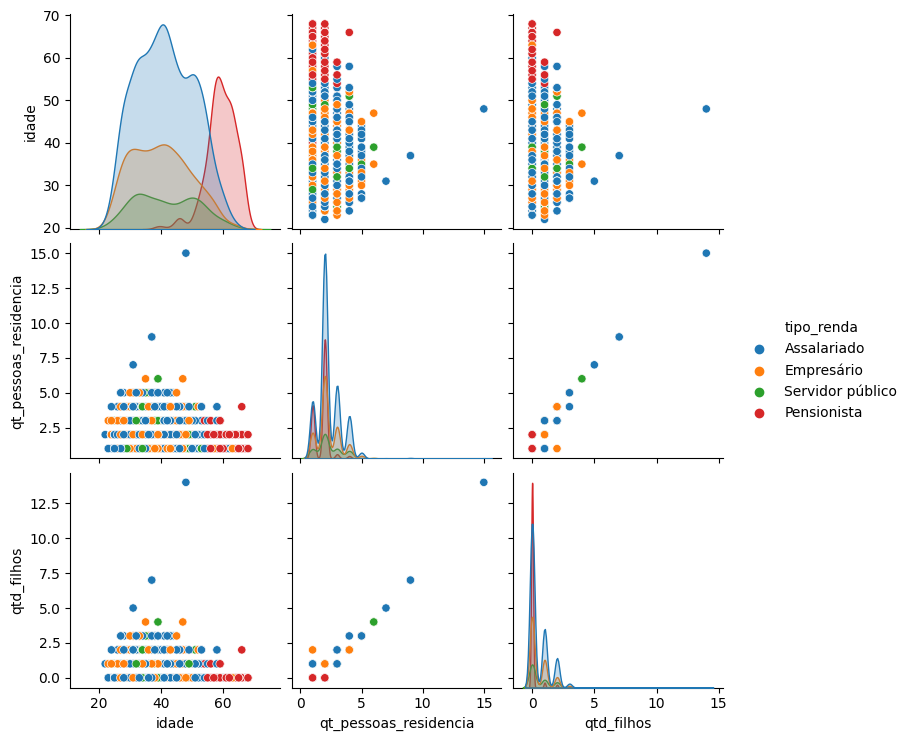

In [37]:
sns.pairplot(
    df_copy_train[["idade","qt_pessoas_residencia","qtd_filhos","tipo_renda"]],
    hue="tipo_renda"
)
plt.show()

d:\OneDrive\Program\01 - scripts-base\EBAC\ebac_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\OneDrive\Program\01 - scripts-base\EBAC\ebac_env\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
d:\OneDrive\Program\01 - scripts-base\EBAC\ebac_env\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
d:\OneDrive\Program\01 - sc

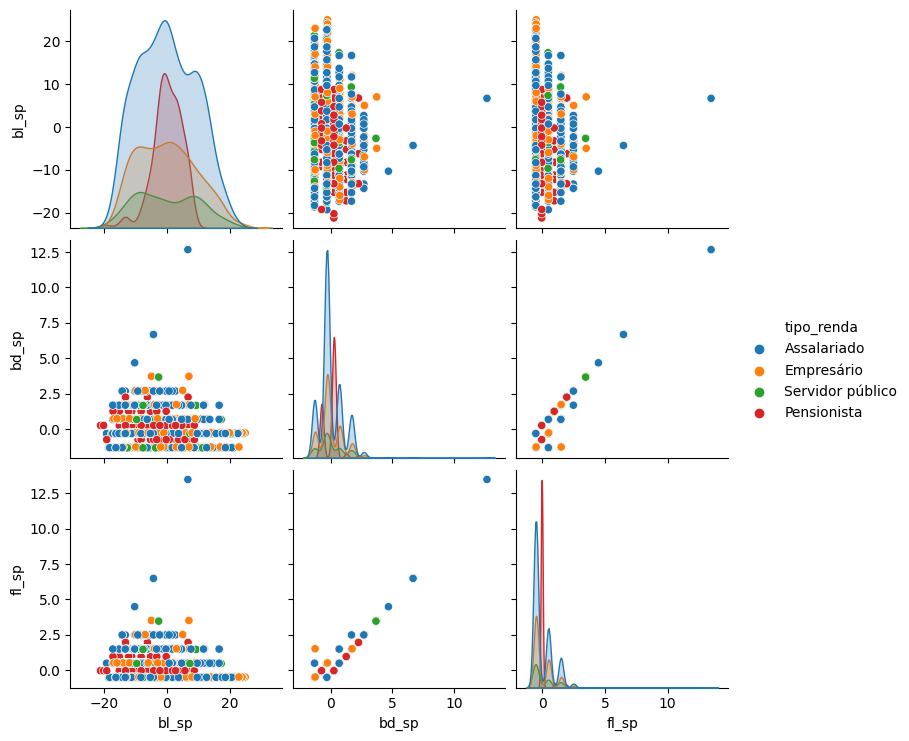

In [38]:
sns.pairplot(
    df_copy_train[["bl_sp","bd_sp","fl_sp","tipo_renda"]],
    hue="tipo_renda"
)
plt.show()

In [39]:
# Obtendo a primeira regreção com todas as variáveis
formula = '''
            renda_log ~ 
            C(tipo_renda, Treatment('Pensionista')) +
            idade +
            qt_pessoas_residencia +
            qtd_filhos +
            tempo_emprego_lowess
'''
reg_redc_varia = smf.ols(formula=formula, data=df_copy_train).fit()

reg_redc_varia.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              renda_log   R-squared:                       0.403
Model:                            OLS   Adj. R-squared:                  0.402
Method:                 Least Squares   F-statistic:                     341.7
Date:                Sun, 29 Dec 2024   Prob (F-statistic):               0.00
Time:                        18:59:37   Log-Likelihood:                -4160.0
No. Observations:                3551   AIC:                             8336.
Df Residuals:                    3543   BIC:                             8385.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================================================================
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------
Intercept                                                       3.5846      0.146     24.602      0.000       3.299       3.870
C(tipo_renda, Treatment('Pensionista'))[T.Assalariado]         -1.2700      0.067    -18.868      0.000      -1.402      -1.138
C(tipo_renda, Treatment('Pensionista'))[T.Empresário]          -1.1823      0.068    -17.269      0.000      -1.317      -1.048
C(tipo_renda, Treatment('Pensionista'))[T.Servidor público]    -1.3199      0.080    -16.543      0.000      -1.476      -1.163
idade                                                           0.0035      0.002      2.099      0.036       0.000       0.007
qt_pessoas_residencia                                          -0.0203      0.032     -0.638      0.523      -0.083       0.042
qtd_filhos                                                     -0.0139      0.039     -0.359      0.719      -0.089       0.062
tempo_emprego_lowess                                            0.7718      0.018     43.812      0.000       0.737       0.806
==============================================================================
Omnibus:                       40.882   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.857
Skew:                           0.245   Prob(JB):                     1.34e-09
Kurtosis:                       2.811   Cond. No.                         525.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
# Obtendo a primeira regreção com todas as variáveis
formula = '''
            renda_log ~ 
            C(tipo_renda, Treatment('Pensionista')) +
            bl_sp + 
            bd_sp + 
            fl_sp +
            tempo_emprego_lowess
'''
reg_redc_vif = smf.ols(formula=formula, data=df_copy_train).fit()

reg_redc_vif.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              renda_log   R-squared:                       0.403
Model:                            OLS   Adj. R-squared:                  0.402
Method:                 Least Squares   F-statistic:                     341.7
Date:                Sun, 29 Dec 2024   Prob (F-statistic):               0.00
Time:                        18:59:38   Log-Likelihood:                -4160.0
No. Observations:                3551   AIC:                             8336.
Df Residuals:                    3543   BIC:                             8385.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================================================================
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------
Intercept                                                       3.7548      0.128     29.423      0.000       3.505       4.005
C(tipo_renda, Treatment('Pensionista'))[T.Assalariado]         -1.3505      0.054    -24.823      0.000      -1.457      -1.244
C(tipo_renda, Treatment('Pensionista'))[T.Empresário]          -1.2662      0.055    -23.000      0.000      -1.374      -1.158
C(tipo_renda, Treatment('Pensionista'))[T.Servidor público]    -1.3998      0.069    -20.275      0.000      -1.535      -1.264
bl_sp                                                           0.0035      0.002      2.099      0.036       0.000       0.007
bd_sp                                                          -0.0203      0.032     -0.638      0.523      -0.083       0.042
fl_sp                                                          -0.0139      0.039     -0.359      0.719      -0.089       0.062
tempo_emprego_lowess                                            0.7718      0.018     43.812      0.000       0.737       0.806
==============================================================================
Omnibus:                       40.882   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.857
Skew:                           0.245   Prob(JB):                     1.34e-09
Kurtosis:                       2.811   Cond. No.                         99.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Ajustes

Faça os ajustes que julgar necessários no modelo e compare as métricas de desempenho do modelo original e ajustado na base de testes.

In [41]:
# Define a suavização dos dados na variável lowess
lowess = sm.nonparametric.lowess(df_copy_test['renda_log'], df_copy_test['tempo_emprego'], frac=1/9)

# Valores de Y suavizados
lowess_x = lowess[:, 0]
lowess_y = lowess[:, 1]


# Roda a interpolação do scipy
f = interp1d(lowess_x, lowess_y, bounds_error=False)

df_copy_test.loc[:, 'tempo_emprego_lowess'] = f(df_copy_test['tempo_emprego'])
df_copy_test.head()

d:\OneDrive\Program\01 - scripts-base\EBAC\ebac_env\lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda_log,tempo_emprego_lowess
288555,M,N,N,1,Assalariado,Superior incompleto,Casado,Aluguel,31,4.953425,3.0,8.933307,8.624203
57507,F,N,S,0,Pensionista,Médio,Casado,Governamental,58,7.778275,2.0,8.183009,10.314907
575463,F,S,S,0,Empresário,Superior incompleto,Casado,Casa,27,4.767123,2.0,7.846856,8.717691
251963,F,S,S,0,Assalariado,Superior completo,União,Casa,43,9.512329,2.0,10.947159,9.257867
376034,F,N,S,0,Servidor público,Médio,Viúvo,Casa,54,16.068493,1.0,12.235219,10.194430


In [42]:
medias_bl = df_copy_test['idade'].groupby(df_copy_test.tipo_renda).mean()
df_copy_test['bl_sp'] = df_copy_test['idade'] - df_copy_test['tipo_renda'].map(medias_bl)

medias_bd = df_copy_test['qt_pessoas_residencia'].groupby(df_copy_test.tipo_renda).mean()
df_copy_test['bd_sp'] = df_copy_test['qt_pessoas_residencia'] - df_copy_test['tipo_renda'].map(medias_bd)

medias_bf = df_copy_test['qtd_filhos'].groupby(df_copy_test.tipo_renda).mean()
df_copy_test['fl_sp'] = df_copy_test['qtd_filhos'] - df_copy_test['tipo_renda'].map(medias_bf)

df_copy_test[['bl_sp', 'bd_sp', 'fl_sp']].corr(method='spearman')

,bl_sp,bd_sp,fl_sp
bl_sp,1.000000,-0.260874,-0.336886
bd_sp,-0.260874,1.000000,0.790277
fl_sp,-0.336886,0.790277,1.000000


In [43]:
print(f"R²: {reg_redc.rsquared:.4f}")
print(f"R²: {reg_redc_out.rsquared:.4f}")
print(f"R²: {reg_redc_varia.rsquared:.4f}")
print(f"R²: {reg_redc_vif.rsquared:.4f}")

R²: 0.3942
R²: 0.4011
R²: 0.4031
R²: 0.4031


In [44]:
df_copy_test['pred_reg_redc'] = reg_redc.predict(df_copy_test)
df_copy_test['pred_reg_redc_out'] = reg_redc_out.predict(df_copy_test)
df_copy_test['pred_reg_redc_varia'] = reg_redc_varia.predict(df_copy_test)
df_copy_test['pred_reg_redc_vif'] = reg_redc_vif.predict(df_copy_test)

df_copy_test.head()

,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda_log,tempo_emprego_lowess,bl_sp,bd_sp,fl_sp,pred_reg_redc,pred_reg_redc_out,pred_reg_redc_varia,pred_reg_redc_vif
288555,M,N,N,1,Assalariado,Superior incompleto,Casado,Aluguel,31,4.953425,3.0,8.933307,8.624203,-10.239382,0.656371,0.444015,8.572845,9.050220,9.004150,9.005378
57507,F,N,S,0,Pensionista,Médio,Casado,Governamental,58,7.778275,2.0,8.183009,10.314907,-1.064516,0.290323,-0.010753,12.161283,11.767689,11.707211,11.706478
575463,F,S,S,0,Empresário,Superior incompleto,Casado,Casa,27,4.767123,2.0,7.846856,8.717691,-14.510000,-0.070000,-0.340000,8.794958,9.212342,9.184232,9.172582
251963,F,S,S,0,Assalariado,Superior completo,União,Casa,43,9.512329,2.0,10.947159,9.257867,1.760618,-0.343629,-0.555985,9.212303,9.549218,9.569143,9.570370
376034,F,N,S,0,Servidor público,Médio,Viúvo,Casa,54,16.068493,1.0,12.235219,10.194430,12.687500,-1.583333,-0.750000,10.212302,10.233892,10.300720,10.309809


Pearson: 0.22
p-value: 0.00


d:\OneDrive\Program\01 - scripts-base\EBAC\ebac_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\OneDrive\Program\01 - scripts-base\EBAC\ebac_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


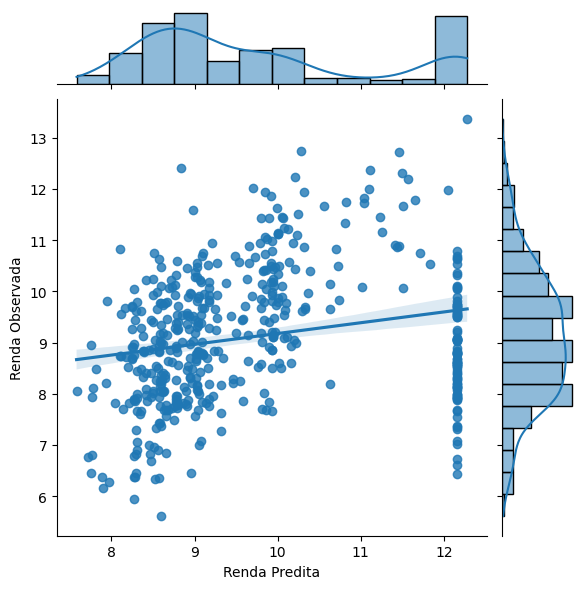

In [45]:
r, p = pearsonr(df_copy_test['renda_log'], df_copy_test['pred_reg_redc'])
print(f"Pearson: {r:.2f}\np-value: {p:.2f}")

sns.jointplot(
    x='pred_reg_redc',
    y='renda_log',
    kind="reg",
    data=df_copy_test,
)
plt.xlabel("Renda Predita")
plt.ylabel("Renda Observada")
plt.show()

Pearson: 0.23
p-value: 0.00


d:\OneDrive\Program\01 - scripts-base\EBAC\ebac_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\OneDrive\Program\01 - scripts-base\EBAC\ebac_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


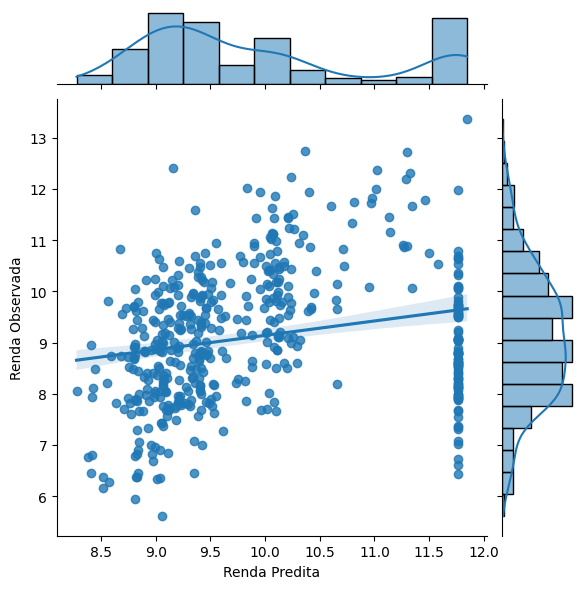

In [46]:
r, p = pearsonr(df_copy_test['renda_log'], df_copy_test['pred_reg_redc_out'])
print(f"Pearson: {r:.2f}\np-value: {p:.2f}")

sns.jointplot(
    x='pred_reg_redc_out',
    y='renda_log',
    kind="reg",
    data=df_copy_test,
)
plt.xlabel("Renda Predita")
plt.ylabel("Renda Observada")
plt.show()

Pearson: 0.23
p-value: 0.00


d:\OneDrive\Program\01 - scripts-base\EBAC\ebac_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\OneDrive\Program\01 - scripts-base\EBAC\ebac_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


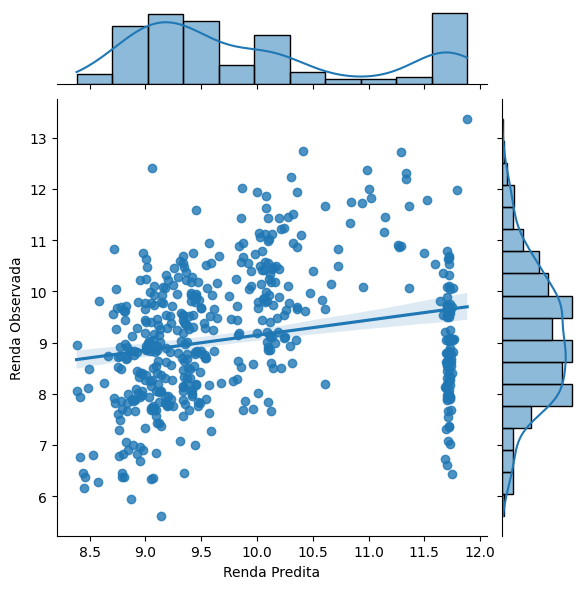

In [47]:
r, p = pearsonr(df_copy_test['renda_log'], df_copy_test['pred_reg_redc_varia'])
print(f"Pearson: {r:.2f}\np-value: {p:.2f}")

sns.jointplot(
    x='pred_reg_redc_varia',
    y='renda_log',
    kind="reg",
    data=df_copy_test,
)
plt.xlabel("Renda Predita")
plt.ylabel("Renda Observada")
plt.show()

Pearson: 0.24
p-value: 0.00


d:\OneDrive\Program\01 - scripts-base\EBAC\ebac_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\OneDrive\Program\01 - scripts-base\EBAC\ebac_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


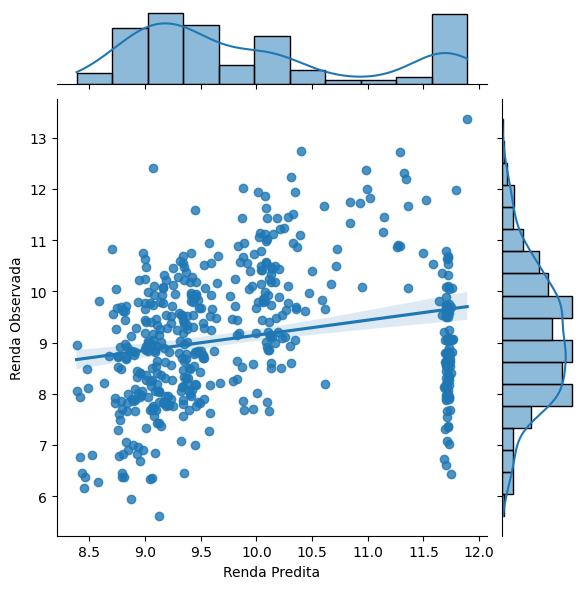

In [48]:
r, p = pearsonr(df_copy_test['renda_log'], df_copy_test['pred_reg_redc_vif'])
print(f"Pearson: {r:.2f}\np-value: {p:.2f}")

sns.jointplot(
    x='pred_reg_redc_vif',
    y='renda_log',
    kind="reg",
    data=df_copy_test,
)
plt.xlabel("Renda Predita")
plt.ylabel("Renda Observada")
plt.show()

## Conclussão
- O modelo padrão obteve R² de 0,14, o melhor modelo obteve R² de 0,47 com método Lowess.

- Na base de testes o modelo Lowess teve Pearson: 0.70 e p-value: 0.03